# CNN electronic music label classification 1 minute chunk

### Import libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils import data
import os
import tqdm as tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Class definition
Dataset and CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, gap_h, gap_w, num_class=9):
        super(CNN, self).__init__()

        # init bn
        self.bn_init = nn.BatchNorm2d(1)

        # layer 1
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d((2, 4))

        # layer 2
        self.conv_2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d((2, 4))

        # layer 3
        self.conv_3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)
        self.mp_3 = nn.MaxPool2d((2, 4))

        # layer 4
        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(128)
        self.mp_4 = nn.MaxPool2d((3, 5))

        # layer 5
        self.conv_5 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_5 = nn.BatchNorm2d(64)
        self.mp_5 = nn.MaxPool2d((4, 4))
        
        # Global Average Pooling
        self.gap = nn.AvgPool2d((1, gap_w), stride=(1, 1))

        # classifier
        self.dense = nn.Linear(64, num_class)

    def forward(self, x):
        x = x.unsqueeze(1)

        # init bn
        x = self.bn_init(x)
        # layer 1
        x = self.mp_1(nn.ELU()(self.bn_1(self.conv_1(x))))
        # layer 2
        x = self.mp_2(nn.ELU()(self.bn_2(self.conv_2(x))))
        # layer 3
        x = self.mp_3(nn.ELU()(self.bn_3(self.conv_3(x))))
        # layer 4
        x = self.mp_4(nn.ELU()(self.bn_4(self.conv_4(x))))
        # layer 5
        x = self.mp_5(nn.ELU()(self.bn_5(self.conv_5(x))))
        x = self.gap(x)
        # classifier
        x = x.view(x.size(0), -1)
        x = nn.Dropout(0.5)(x)
        logit = self.dense(x)

        return logit

Reading labels

In [ ]:
count = 0
count_labels = []
labels = []
labels_dict = dict()
main_dir = '/content/drive/My Drive/archives/mel_specs/1_min/train'

for root, dirs, files in os.walk (main_dir):
    count += 1
    if count==1:
        labels = [label for label in dirs if not label.startswith('.')]
    else:
        break
print(labels)

total_count = 0
for l in labels:
    count = 0
    for root, dirs, files in os.walk(main_dir+'/'+l):
        for file in files:
            count+=1
            total_count+=1

    count_labels.append(count)   
    print(l,' = ',count)
print('TOTAL = ',total_count)


['suaraarchive', 'stilvortalentarchive', 'ninjatunearchive', 'mordarchive', 'littlehelpersarchive', 'kompaktarchive', 'bar25archive', 'defectedarchive', 'chillhoparchive']
suaraarchive  =  1686
stilvortalentarchive  =  1585
ninjatunearchive  =  1004
mordarchive  =  1266
littlehelpersarchive  =  1494
kompaktarchive  =  1632
bar25archive  =  1805
defectedarchive  =  2215
chillhoparchive  =  577
TOTAL =  13264


### Initialization dataset, model, criterion and optimizer

Train and Test DataLoader initialization

In [ ]:
def train_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

def test_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample    

In [ ]:
train_root = '/content/drive/My Drive/archives/mel_specs/1_min/train'
test_root = '/content/drive/My Drive/archives/mel_specs/1_min/test'


train_dataset = torchvision.datasets.DatasetFolder(root=train_root, loader=train_loader,  extensions='.npy', transform=None, target_transform=None, is_valid_file=None)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = torchvision.datasets.DatasetFolder(root=test_root, loader=test_loader,  extensions='.npy', transform=None, target_transform=None, is_valid_file=None)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=4)

Model, criterion and optimizer initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
          nn.init.xavier_normal_(m.weight.data)       

In [ ]:
torch.manual_seed(42)
device = 'cuda'
model = CNN(num_class=9, gap_h=1, gap_w=2)
model.cuda(device)

class_weights = torch.Tensor([7.86, 8.36, 13.2, 10.47, 8.87, 8.12, 7.34, 5.98, 22.98])

criterion = nn.CrossEntropyLoss(weight = class_weights)  
criterion = criterion.to(device)   #move back to GPU 
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4) #was at 1e-4 originally
model.apply(weights_init)

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

Checkpoint loading

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/archives/mel_specs/1_min/checkpointw.tar', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
cost_list = checkpoint['cost_list']
model.cuda()

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

### Training

In [ ]:
cost_list = []
#pred_list = []
epoch = 0
COST=0

In [ ]:

for epoch in tqdm.tqdm(range(epoch,200)):
    COST=0
    model.train()
    for i,data in enumerate(train_loader):
        x,y = data
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()      
        y_=model(x)
        loss=criterion(y_,y)
        loss.backward()
        optimizer.step()
        COST+=loss.data
        
        if i % 10 == 0:
            print(loss)
    
    cost_list.append(COST)
    print('COST epoch',epoch, ' = ', cost_list)

    if epoch % 1 == 0 :
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': COST,
              'cost_list': cost_list,
              
              }, '/content/drive/My Drive/archives/mel_specs/1_min/checkpointw.tar')
    
    model.eval()

    pred_list=[] 
    y_list = []

    for i, data in enumerate(test_loader):
      x, y = data
      x = x.cuda()
      pred = model(x)

      # append
      pred = pred.detach().cpu()
      for _p in pred:
          pred_list.append(int(_p.argmax()))
      for _y in y:
          y_list.append(int(_y))
          
      if i % 10 == 0:
          print('Files processed = ', i)

    accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)

    print('Accuracy epoch',epoch, ' = ',accuracy)
      

  0%|          | 0/154 [00:00<?, ?it/s]

tensor(2.1995, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1624, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1200, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1187, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4778, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9076, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1556, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1428, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1309, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0747, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0462, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8813, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1631, device='cuda:0', grad_fn=<NllLossBackward

  1%|          | 1/154 [21:14<54:10:43, 1274.79s/it]

Accuracy epoch 46  =  0.22640364188163883
tensor(2.2490, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1314, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0784, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3275, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1510, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9026, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1338, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1763, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4924, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9471, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9411, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0428, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2916, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2320, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6853, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1653,

  1%|▏         | 2/154 [37:12<49:48:11, 1179.55s/it]

Accuracy epoch 47  =  0.2251896813353566
tensor(1.8643, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1672, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8992, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9018, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2360, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0675, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8445, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0198, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9337, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9092, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8959, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2697, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7968, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9507, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2772, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9100, 

  2%|▏         | 3/154 [50:55<44:59:56, 1072.82s/it]

Accuracy epoch 48  =  0.21153262518968133
tensor(2.0877, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9679, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0595, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1886, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9391, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1113, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8212, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1033, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9319, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4936, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1242, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8147, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8206, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7540, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9744,

  3%|▎         | 4/154 [1:04:13<41:15:49, 990.33s/it]

Accuracy epoch 49  =  0.2251896813353566
tensor(1.6496, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9700, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0371, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8801, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2987, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0538, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9122, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4379, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5956, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9945, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7653, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8576, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0449, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9716, 

  3%|▎         | 5/154 [1:18:50<39:35:03, 956.40s/it]

Accuracy epoch 50  =  0.22397572078907435
tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1988, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2307, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1728, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1996, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5317, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7787, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1973, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1042, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9866, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6849, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0856, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0575, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1503, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1892, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9393, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7105,

  4%|▍         | 6/154 [1:31:53<37:10:34, 904.29s/it]

Accuracy epoch 51  =  0.23186646433990896
tensor(2.0417, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8877, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2363, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2301, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9385, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0939, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1129, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0935, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7459, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9030, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9879, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9456, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1170, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7967, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0468,

  5%|▍         | 7/154 [1:45:11<35:37:19, 872.38s/it]

Accuracy epoch 52  =  0.21972685887708648
tensor(2.1251, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4613, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7831, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0859, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1283, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9584, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0060, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0333, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6287, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7317, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8054, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7972, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0615, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1301, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5265,

  5%|▌         | 8/154 [1:58:55<34:47:12, 857.76s/it]

Accuracy epoch 53  =  0.2188163884673748
tensor(2.0220, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7411, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1282, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2170, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8471, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6348, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9519, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0971, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0486, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.6039, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8300, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1991, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8537, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1284, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8852, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0153, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7604, 

  6%|▌         | 9/154 [2:12:19<33:54:25, 841.83s/it]

Accuracy epoch 54  =  0.22579666160849773
tensor(1.7980, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9021, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8363, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8187, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8634, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9300, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8671, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0870, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9168, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3408, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0895, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0529, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1284, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5258,

  6%|▋         | 10/154 [2:25:54<33:20:26, 833.52s/it]

Accuracy epoch 55  =  0.2306525037936267
tensor(1.9407, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9963, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0191, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1319, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9477, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1349, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0467, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9919, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0239, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7765, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9804, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2634, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2273, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8743, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0640, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8797, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9288, 

  7%|▋         | 11/154 [2:39:33<32:56:45, 829.41s/it]

Accuracy epoch 56  =  0.22974203338391502
tensor(2.0828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9432, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2652, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7059, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2187, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7937, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9816, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0775, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7504, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7728, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8831, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1669, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8389, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5973,

  8%|▊         | 12/154 [2:55:38<34:19:15, 870.11s/it]

Accuracy epoch 57  =  0.22458270106221548
tensor(2.0117, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0503, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8140, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7369, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9107, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2575, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1502, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9929, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0631, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0829, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6959, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0307, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7324, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0512, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3134, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0620,

  8%|▊         | 13/154 [3:10:26<34:17:20, 875.47s/it]

Accuracy epoch 58  =  0.22792109256449167
tensor(1.9695, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0905, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0420, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0882, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4911, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2324, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6356, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9553, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7552, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0083, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1745, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9908, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9908, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3136, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8004, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0799, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9459,

  9%|▉         | 14/154 [3:24:33<33:42:12, 866.66s/it]

Accuracy epoch 59  =  0.22701062215477996
tensor(2.0527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7867, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0017, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8108, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0203, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0639, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2221, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9168, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1811, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9811, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9356, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8123, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2587, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8055, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8465, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9083,

 10%|▉         | 15/154 [3:38:16<32:57:41, 853.68s/it]

Accuracy epoch 60  =  0.23884673748103186
tensor(2.1600, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9844, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0796, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7689, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0879, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8318, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0025, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7211, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1120, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0789, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0248, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0842, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2161, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0195, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8920,

 10%|█         | 16/154 [3:52:14<32:32:54, 849.09s/it]

Accuracy epoch 61  =  0.2321699544764795
tensor(1.8029, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7849, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9132, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9362, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0079, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8709, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8477, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1734, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8365, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1392, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9277, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8786, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9654, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8291, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2120, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8424, 

 11%|█         | 17/154 [4:07:49<33:17:29, 874.82s/it]

Accuracy epoch 62  =  0.23459787556904402
tensor(1.9269, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7874, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1225, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0822, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9446, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7354, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1013, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1163, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9200, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1213, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1742, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7811, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7622, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8526, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6773, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2567,

 12%|█▏        | 18/154 [4:22:43<33:15:48, 880.51s/it]

Accuracy epoch 63  =  0.23611532625189682
tensor(1.6142, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8781, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9088, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8425, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0124, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0573, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2338, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7347, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0263, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8101, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7746, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0418, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9386, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0259, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8162, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8900, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9649,

 12%|█▏        | 19/154 [4:37:31<33:06:12, 882.76s/it]

Accuracy epoch 64  =  0.21699544764795145
tensor(2.0022, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8653, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9874, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1165, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0363, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0209, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1169, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2797, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7450, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9546, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0776, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1993, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6815, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0343, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0491, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2636, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8944,

 13%|█▎        | 20/154 [4:51:35<32:25:51, 871.28s/it]

Accuracy epoch 65  =  0.22276176024279212
tensor(1.5223, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7938, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0986, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7278, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1639, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1656, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1709, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7031, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0498, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1063, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3058, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0173, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1565, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0896, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8438, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0214, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0316,

 14%|█▎        | 21/154 [5:07:53<33:21:44, 903.04s/it]

Accuracy epoch 66  =  0.23641881638846737
tensor(2.0790, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4831, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8793, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8501, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4877, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8554, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9483, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2492, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9512, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6405, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8099, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9180, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9366, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9892, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2426, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7596,

 14%|█▍        | 22/154 [5:22:53<33:05:13, 902.38s/it]

Accuracy epoch 67  =  0.24127465857359637
tensor(1.6833, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7970, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6806, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9301, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1371, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8847, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7920, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8701, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7840, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9415, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8887, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0149, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1491, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9790, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9193, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9540,

 15%|█▍        | 23/154 [5:38:44<33:22:04, 916.98s/it]

Accuracy epoch 68  =  0.23520485584218512
tensor(2.1246, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2622, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9820, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6684, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2041, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8287, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9136, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9431, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9278, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9470, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9538, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9256, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8229, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8923, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9541,

 16%|█▌        | 24/154 [5:53:43<32:54:40, 911.39s/it]

Accuracy epoch 69  =  0.24036418816388466
tensor(2.2365, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0204, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2419, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8856, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2407, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0446, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7702, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1760, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8143, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2851, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0905, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.8082, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7389, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9035, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7201, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8609,

 16%|█▌        | 25/154 [6:10:13<33:30:04, 934.92s/it]

Accuracy epoch 70  =  0.2400606980273141
tensor(1.8494, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9710, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8595, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9125, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0693, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0634, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.5279, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8374, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0686, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0644, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7772, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9580, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9080, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8996, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8791, 

 17%|█▋        | 26/154 [6:27:17<34:11:40, 961.72s/it]

Accuracy epoch 71  =  0.2370257966616085
tensor(1.8352, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2143, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9289, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0204, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9698, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0106, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1209, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8621, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9902, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8711, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7816, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7906, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8569, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1238, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7739, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5325, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6951, 

 18%|█▊        | 27/154 [6:44:43<34:48:56, 986.90s/it]

Accuracy epoch 72  =  0.23611532625189682
tensor(2.0476, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2372, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8018, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8403, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9602, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0114, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9321, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.7800, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0853, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7982, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2173, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1279, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9183, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9304, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0651, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9812,

 18%|█▊        | 28/154 [7:01:52<34:59:08, 999.59s/it]

Accuracy epoch 73  =  0.23186646433990896
tensor(1.8628, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9201, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7655, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7701, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0407, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2360, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9345, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8141, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0327, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0063, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9380, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2190, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1938, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9113, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.5568,

 19%|█▉        | 29/154 [7:17:49<34:15:59, 986.88s/it]

Accuracy epoch 74  =  0.23823975720789076
tensor(2.3444, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8779, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7475, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2370, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6721, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7136, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2750, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7686, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0344, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9995, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9891, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9940, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7327, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0116, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3095, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7183, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8460,

 19%|█▉        | 30/154 [7:33:09<33:18:05, 966.82s/it]

Accuracy epoch 75  =  0.23004552352048557
tensor(2.0736, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0558, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0343, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8826, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1150, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0965, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9494, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8325, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0159, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1352, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7874, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2726, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0221, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9729, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8213,

 20%|██        | 31/154 [7:48:31<32:34:33, 953.44s/it]

Accuracy epoch 76  =  0.25371775417298936
tensor(2.2053, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0241, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1052, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4700, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3378, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0488, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8506, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0285, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8593, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2392, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2630, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3251, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1515, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8964, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9470, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7187,

 21%|██        | 32/154 [8:03:45<31:54:14, 941.43s/it]

Accuracy epoch 77  =  0.2449165402124431
tensor(1.8727, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9760, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5889, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9699, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8409, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1286, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9423, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8847, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.5138, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0630, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0867, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7857, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8192, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0994, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8404, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2345, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1286, 

 21%|██▏       | 33/154 [8:19:00<31:22:54, 933.67s/it]

Accuracy epoch 78  =  0.24218512898330805
tensor(2.3313, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8351, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7715, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8328, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9188, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0624, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0348, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0057, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8094, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1122, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9078, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7176, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8611, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7726, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6255,

 22%|██▏       | 34/154 [8:34:21<30:59:35, 929.79s/it]

Accuracy epoch 79  =  0.25159332321699546
tensor(1.8830, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0918, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9611, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2623, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0494, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9839, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0786, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3045, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6207, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6839, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8092, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0372, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0026, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6293, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8748, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8559,

 23%|██▎       | 35/154 [8:49:25<30:28:39, 922.01s/it]

Accuracy epoch 80  =  0.24764795144157814
tensor(2.1117, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2957, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9053, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2576, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6793, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6686, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1304, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8443, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9326, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0295, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8842, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8825, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9420, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8628, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.5218, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1544,

 23%|██▎       | 36/154 [9:04:21<29:58:14, 914.36s/it]

Accuracy epoch 81  =  0.24946889226100152
tensor(1.8266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8464, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2939, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7117, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9937, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8503, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8873, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9074, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8310, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7248, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3399, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0484, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9573, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1803, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8422, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9438,

 24%|██▍       | 37/154 [9:20:08<30:01:41, 923.95s/it]

Accuracy epoch 82  =  0.247040971168437
tensor(1.6619, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8841, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9447, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4952, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7428, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2809, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9003, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9055, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9738, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1796, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6273, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0794, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9357, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8118, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8948, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3306, d

 25%|██▍       | 38/154 [9:35:58<30:01:44, 931.93s/it]

Accuracy epoch 83  =  0.2509863429438543
tensor(2.0551, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1801, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2210, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9559, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0381, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6532, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0297, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6371, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7400, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2076, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9274, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9138, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8725, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0232, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6502, 

 25%|██▌       | 39/154 [9:51:33<29:47:45, 932.74s/it]

Accuracy epoch 84  =  0.24309559939301972
tensor(2.0397, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0816, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7083, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9507, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1311, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8877, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8241, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9899, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7883, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8362, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2788, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9340, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8394, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9538, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0109, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8573,

In [ ]:
 n_classes = torch.unique(y)
 print(n_classes)

tensor([0, 1, 2, 3, 4, 5, 7, 8], device='cuda:0')


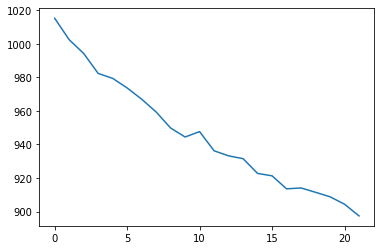

In [ ]:
plt.plot(cost_list)

In [ ]:
plt.plot(cost_list, c='blue', pred_list, c='red')
#or 
#plt.plot(cost_list, label=trainloss)
#plt.plot(pred_list, label=testloss)
plt.show()

SyntaxError: ignored

### Evaluation

Loading model

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/archives/mel_specs/1_min/checkpointtr0.tar', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
cost_list = checkpoint['cost_list']
model.cuda()

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

In [ ]:
y_list = []
pred_list = []
model.eval()
for i, data in enumerate(test_loader):
    x, y = data
    x = x.cuda()
    pred = model(x)
    
    pred = pred.detach().cpu()
    for _p in pred:
          pred_list.append(int(_p.argmax()))
    for _y in y:
          y_list.append(int(_y))
        
    if i % 10 == 0:
        print('Batch processed = ', i)
    

Batch processed =  0
Batch processed =  10
Batch processed =  20
Batch processed =  30
Batch processed =  40
Batch processed =  50
Batch processed =  60
Batch processed =  70
Batch processed =  80
Batch processed =  90
Batch processed =  100


Accuracy calculation

In [ ]:
accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)
print(accuracy)

0.5447647951441578


Confusion matrix calculation

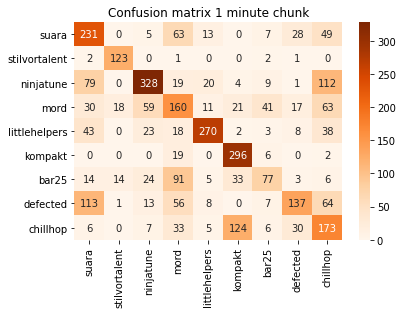

In [ ]:
import sklearn.metrics
import seaborn
 
lab = [lab.split('archive')[0] for lab in labels]
plt.figure()
plt.title('Confusion matrix 1 minute chunk')
cm = sklearn.metrics.confusion_matrix(np.asarray(y_list), np.asarray(pred_list))
seaborn.heatmap(cm, annot=True, xticklabels=lab, yticklabels=lab, fmt="d", cmap = "Oranges")

F

In [ ]:
sklearn.metrics.f1_score(y_list, pred_list, average='micro')

0.5447647951441578

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_list, pred_list))

              precision    recall  f1-score   support

           0       0.45      0.58      0.51       396
           1       0.79      0.95      0.86       129
           2       0.71      0.57      0.64       572
           3       0.35      0.38      0.36       420
           4       0.81      0.67      0.73       405
           5       0.62      0.92      0.74       323
           6       0.49      0.29      0.36       267
           7       0.61      0.34      0.44       399
           8       0.34      0.45      0.39       384

    accuracy                           0.54      3295
   macro avg       0.57      0.57      0.56      3295
weighted avg       0.57      0.54      0.54      3295

